# Dependency specification:

Code to use and update requirement.txt
pip install -r requirements.txt
Update requirements.txt (add xgboost)


### Code for shah-dev branch
git checkout shah-dev
git add .
git commit -m "Work on strategy testing"
git push origin shah-dev



In [3]:
# DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))  # adds project root

In [5]:
import pandas as pd
import yfinance as yf
from src.functions.plot_position import plot_positions_ma
import numpy as np
from src.functions.position_VB import positionVB
import plotly.express as px
from src.functions.plot_position import plot_positions_2mas
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Groups of assets

The groups of assets include:

- **Group 1** – two assets (1-minute frequency), **traded during NYSE sessions** on working days between **9:30 and 16:00 CET**:
  - **SP** – futures contract for S&P 500 index (transaction cost = 12$, point value = 50$).
  - **NQ** – futures contract for NASDAQ index (transaction cost = 12$, point value = 20$).


In [6]:
file_path = "/Users/shah/CODE_BOOK_3/code_document/hfdProject/HFD-Final-Project/data/data1_2023_Q1.parquet"

dataQ1 = pd.read_parquet(file_path)
dataQ1

,datetime,NQ,SP
0,2023-01-02 09:31:00+00:00,NaN,NaN
1,2023-01-02 09:32:00+00:00,NaN,NaN
2,2023-01-02 09:33:00+00:00,NaN,NaN
3,2023-01-02 09:34:00+00:00,NaN,NaN
4,2023-01-02 09:35:00+00:00,NaN,NaN
...,...,...,...
25104,2023-03-31 15:56:00+00:00,13175.879,4089.201
25105,2023-03-31 15:57:00+00:00,13180.419,4089.201
25106,2023-03-31 15:58:00+00:00,13180.649,4089.201
25107,2023-03-31 15:59:00+00:00,13187.769,4089.201


In [9]:
dataQ1.dtypes

datetime    datetime64[us, UTC]
NQ                      float64
SP                      float64
NQ_SMA60                float64
NQ_STD60                float64
dtype: object

## Strategy 01

In [10]:
dataQ1['NQ_SMA60'] = dataQ1['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ1['NQ_SMA60'] = dataQ1['NQ_SMA60'].where(~dataQ1['NQ'].isna(), np.nan)
dataQ1['NQ_STD60'] = dataQ1['NQ'].rolling(window = 60, min_periods = 30).std()


In [11]:
pos_flat = np.zeros(len(dataQ1))

dataQ1['position3'] = positionVB(
    signal = dataQ1['NQ'],  # AAPL price is the signal
    lower = dataQ1['NQ_SMA60'] - dataQ1['NQ_STD60'] * 3,  # lower threshold
    upper = dataQ1['NQ_SMA60'] + dataQ1['NQ_STD60'] * 3,  # upper threshold
    pos_flat = pos_flat,  # flat position vector
    strategy = 'mr' 
)


In [12]:
dataQ1["datetime"]

0       2023-01-02 09:31:00+00:00
1       2023-01-02 09:32:00+00:00
2       2023-01-02 09:33:00+00:00
3       2023-01-02 09:34:00+00:00
4       2023-01-02 09:35:00+00:00
                   ...           
25104   2023-03-31 15:56:00+00:00
25105   2023-03-31 15:57:00+00:00
25106   2023-03-31 15:58:00+00:00
25107   2023-03-31 15:59:00+00:00
25108   2023-03-31 16:00:00+00:00
Name: datetime, Length: 25109, dtype: datetime64[us, UTC]

In [13]:
dataQ1 = dataQ1.set_index("datetime")
dataQ1.index

DatetimeIndex(['2023-01-02 09:31:00+00:00', '2023-01-02 09:32:00+00:00',
               '2023-01-02 09:33:00+00:00', '2023-01-02 09:34:00+00:00',
               '2023-01-02 09:35:00+00:00', '2023-01-02 09:36:00+00:00',
               '2023-01-02 09:37:00+00:00', '2023-01-02 09:38:00+00:00',
               '2023-01-02 09:39:00+00:00', '2023-01-02 09:40:00+00:00',
               ...
               '2023-03-31 15:51:00+00:00', '2023-03-31 15:52:00+00:00',
               '2023-03-31 15:53:00+00:00', '2023-03-31 15:54:00+00:00',
               '2023-03-31 15:55:00+00:00', '2023-03-31 15:56:00+00:00',
               '2023-03-31 15:57:00+00:00', '2023-03-31 15:58:00+00:00',
               '2023-03-31 15:59:00+00:00', '2023-03-31 16:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='datetime', length=25109, freq=None)

In [14]:
dataQ1.index[0:1]

DatetimeIndex(['2023-01-02 09:31:00+00:00'], dtype='datetime64[us, UTC]', name='datetime', freq=None)

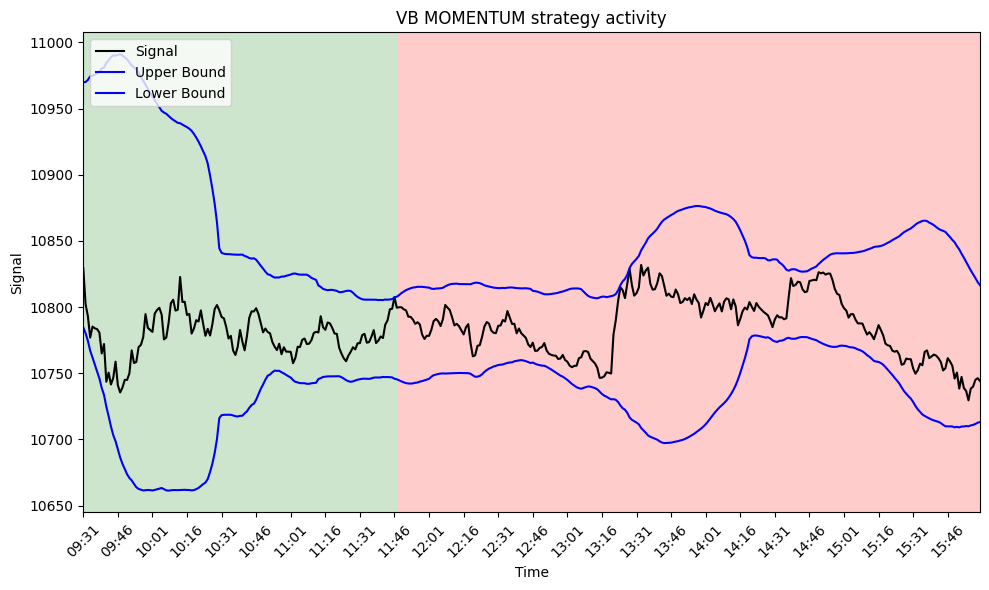

<Axes: title={'center': 'VB MOMENTUM strategy activity'}, xlabel='Time', ylabel='Signal'>

In [15]:
from src.functions.plot_position import plot_positions_vb

# the function requires referencing column names from the data frame

# let's create these for col_lower and col_upper
dataQ1['NQ_VB_lower'] = (dataQ1['NQ_SMA60'] - dataQ1['NQ_STD60'] * 3)
dataQ1['NQ_VB_upper'] = (dataQ1['NQ_SMA60'] + dataQ1['NQ_STD60'] * 3)

plot_positions_vb(
    data_plot = dataQ1, 
    date_plot = '2023-01-05',  
    col_signal = 'NQ', 
    col_lower = 'NQ_VB_lower',
    col_upper = 'NQ_VB_upper',
    col_pos = 'position3',
    title = 'VB MOMENTUM strategy activity')


### Fall Detection and Duration–Depth Analysis
In what time span does the max fall happen?

This analysis identifies **distinct price falls** in the NQ price series and measures how **deep** each fall is relative to how **long** it lasts.

**How a fall is defined**
- A fall **starts** at the first negative return (`NQ[t] < NQ[t−1]`).
- A fall **continues** as long as the price difference is negative.
- A fall **continues** as long as the price remains **above its forward 15-minute mean**.
- A fall **ends** at the first time the price rises above that forward mean.
- Each fall is counted **once** (no overlapping or nested falls).

**Fall Events DataFrame**

`falls_df` contains **non-overlapping price fall events** extracted from the NQ price series.  
Each row represents one complete fall, defined from the first negative return to the point where price recovers relative to its forward 15-period mean.

- `duration_min`: total length of the fall in bars (minutes if 1-minute data)
- `max_fall`: total price drop from the start of the fall to its stopping point

**What the plot shows**
- For each time span (1 min, 2 mins, 3 mins, …), the plot displays the **largest observed price fall** over that duration.
- This reveals how extreme downside risk scales with time:  
  *how bad the worst fall can be if the price keeps dropping for N minutes.*

This provides a **time-based view of downside risk**


<Axes: xlabel='datetime'>

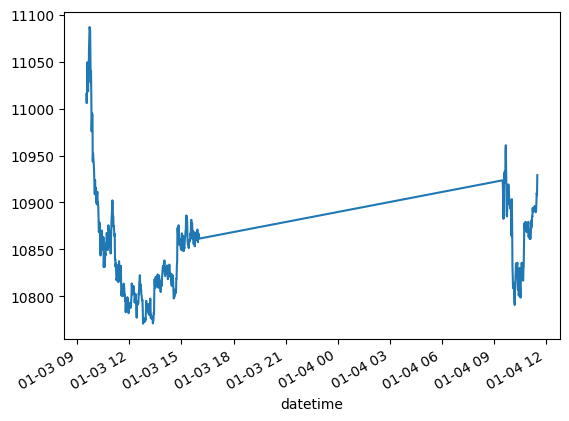

In [18]:
dataQ1["NQ"][100:900].plot()

In [19]:
import numpy as np
import pandas as pd

p = pd.to_numeric(dataQ1["NQ"], errors="coerce").to_numpy()
n = len(p)

fwd15 = pd.Series(p).rolling(15).mean().shift(-14).to_numpy()

falls = []
i = 1

while i < n - 15:
    if not (np.isfinite(p[i]) and np.isfinite(p[i-1]) and np.isfinite(fwd15[i])):
        i += 1
        continue

    # start fall on negative return
    if p[i] < p[i-1]:
        start = i - 1
        peak = p[start]
        i += 1

        # wait for positive returns; decide stop/continue using fwd15 at that time
        while i < n - 15:
            if not (np.isfinite(p[i]) and np.isfinite(p[i-1]) and np.isfinite(fwd15[i])):
                i += 1
                continue

            if p[i] > p[i-1]:  # bounce point
                if p[i] <= fwd15[i]:  # stop fall here
                    trough = p[i]
                    falls.append((i - start, trough - peak))
                    i += 1
                    break
                # else: fall continues; keep waiting for next positive return

            i += 1
    else:
        i += 1

falls_df = pd.DataFrame(falls, columns=["duration_min", "max_fall"])


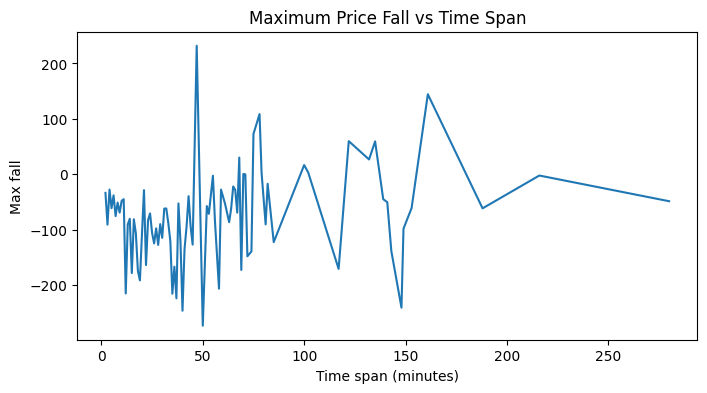

In [20]:
import matplotlib.pyplot as plt

max_fall_by_time = (
    falls_df
    .groupby("duration_min")["max_fall"]
    .min()   # most negative = deepest fall
)

plt.figure(figsize=(8,4))
plt.plot(max_fall_by_time.index, max_fall_by_time.values)
plt.xlabel("Time span (minutes)")
plt.ylabel("Max fall")
plt.title("Maximum Price Fall vs Time Span")
plt.show()

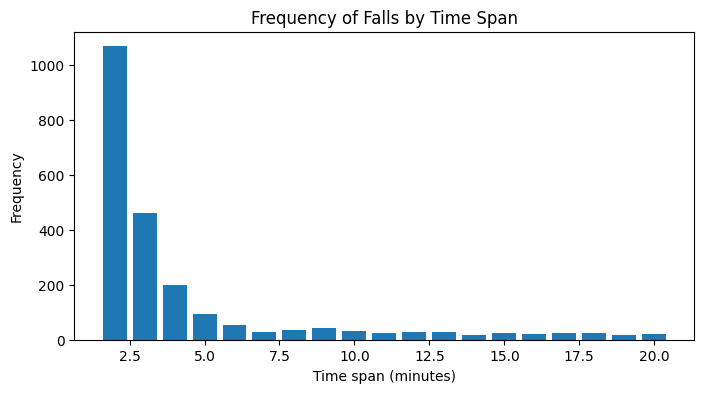

In [21]:
import matplotlib.pyplot as plt
freq = falls_df["duration_min"].value_counts().sort_index()
freq_0_20 = freq.loc[0:20]
plt.figure(figsize=(8,4))
plt.bar(freq_0_20.index, freq_0_20.values)
plt.xlabel("Time span (minutes)")
plt.ylabel("Frequency")
plt.title("Frequency of Falls by Time Span")
plt.show()


In [22]:
import numpy as np

NQ = dataQ1["NQ"].to_numpy()
SMA60 = dataQ1["NQ_SMA60"].to_numpy()
STD60 = dataQ1["NQ_STD60"].to_numpy()

freq = falls_df["duration_min"].value_counts().sort_index()
cdf = freq.cumsum() / freq.sum()

D1 = int(cdf[cdf >= 0.80].index[0])
D2 = int(cdf[cdf >= 0.95].index[0])

z = (NQ - SMA60) / np.where(STD60 ==0, np.nan, STD60)

# since falls_df has no z_min, use global |z| quantiles as band multipliers
z_abs = np.abs(z[np.isfinite(z)])

k1 = float(np.nanquantile(z_abs, 0.80))
k2 = float(np.nanquantile(z_abs, 0.90))
k3 = float(np.nanquantile(z_abs, 0.97))

k1, k2, k3 = sorted([k1, k2, k3])


In [23]:
k1, k2 ,k3

(1.721961975587152, 2.1893750468591424, 3.0804060597791043)

## Strategy 02 (01)

In [26]:
import numpy as np
import pandas as pd
FLIP = True  # set False to keep original

dataQ1["upper_1"] = dataQ1["NQ_SMA60"] + k1 * dataQ1["NQ_STD60"]
dataQ1["upper_2"] = dataQ1["NQ_SMA60"] + k2 * dataQ1["NQ_STD60"]
dataQ1["upper_3"] = dataQ1["NQ_SMA60"] + k3 * dataQ1["NQ_STD60"]

dataQ1["lower_1"] = dataQ1["NQ_SMA60"] - k1 * dataQ1["NQ_STD60"]
dataQ1["lower_2"] = dataQ1["NQ_SMA60"] - k2 * dataQ1["NQ_STD60"]
dataQ1["lower_3"] = dataQ1["NQ_SMA60"] - k3 * dataQ1["NQ_STD60"]

# ---------- Preconditions ----------
NQ = dataQ1["NQ"].to_numpy()
SMA   = dataQ1["NQ_SMA60"].to_numpy()

U1 = dataQ1["upper_1"].to_numpy()
U2 = dataQ1["upper_2"].to_numpy()
L1 = dataQ1["lower_1"].to_numpy()
L2 = dataQ1["lower_2"].to_numpy()

n = len(dataQ1)

# ---------- Outputs ----------
pos    = np.zeros(n, dtype=np.int8)   # -1, 0, +1
regime = np.zeros(n, dtype=np.int8)   # 0 = MR, 1 = MOM

# ---------- State ----------
mode    = 0        # 0 = MR, 1 = MOM
persist = 0        # persistence counter
D1      = 10       # persistence threshold (from freq analysis)

# ---------- Main loop ----------
for t in range(1, n):

    # skip until bands exist
    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    # -----------------------------
    # Track downside persistence
    # -----------------------------
    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    # -----------------------------
    # Regime switch: MR → MOM
    # -----------------------------
    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = -1
        regime[t] = mode
        continue

    # -----------------------------
    # Regime switch: MOM to MR
    # -----------------------------
    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    # -----------------------------
    # Mean Reversion logic
    # -----------------------------
    if mode == 0:

        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = 1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = -1
            else:
                pos[t] = 0

        else:
            # exit MR at mean
            if (pos[t-1] == 1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == -1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        # hold momentum position until regime exit
        pos[t] = pos[t-1]

    regime[t] = mode

# ---------- Save ----------
dataQ1["position_3"] = (-pos if FLIP else pos)
dataQ1["regime_3"]   = regime



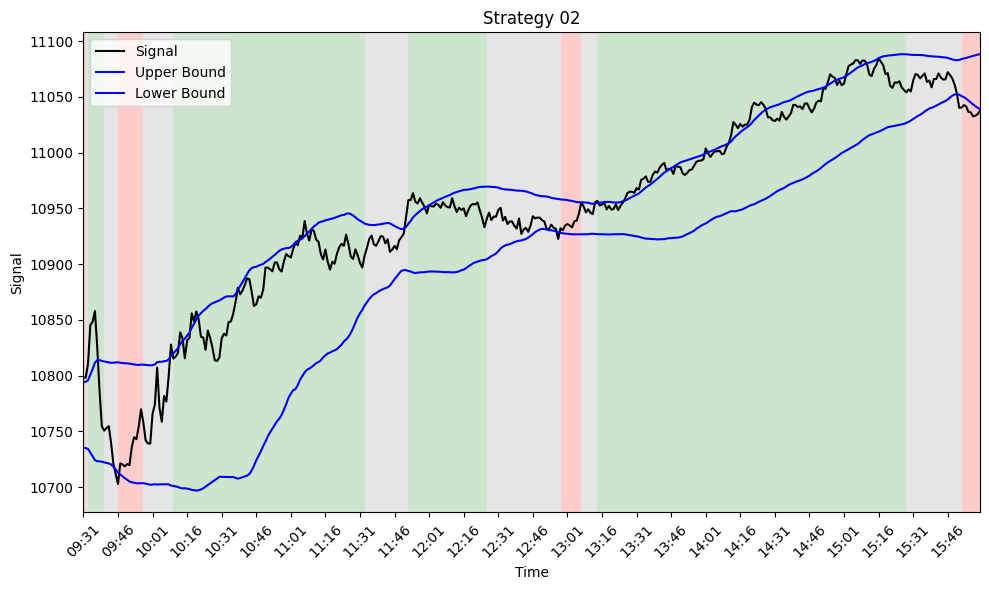

<Axes: title={'center': 'Strategy 02'}, xlabel='Time', ylabel='Signal'>

In [27]:
plot_positions_vb(
    data_plot=dataQ1,
    date_plot="2023-01-06",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 02"
)


## Strategy 02 (02)

In [30]:
import numpy as np
import pandas as pd
FLIP = True
dataQ1["upper_1"] = dataQ1["NQ_SMA60"] + k1 * dataQ1["NQ_STD60"]
dataQ1["upper_2"] = dataQ1["NQ_SMA60"] + k2 * dataQ1["NQ_STD60"]
dataQ1["upper_3"] = dataQ1["NQ_SMA60"] + k3 * dataQ1["NQ_STD60"]

dataQ1["lower_1"] = dataQ1["NQ_SMA60"] - k1 * dataQ1["NQ_STD60"]
dataQ1["lower_2"] = dataQ1["NQ_SMA60"] - k2 * dataQ1["NQ_STD60"]
dataQ1["lower_3"] = dataQ1["NQ_SMA60"] - k3 * dataQ1["NQ_STD60"]

# ---------- Preconditions ----------
NQ = dataQ1["NQ"].to_numpy()
SMA   = dataQ1["NQ_SMA60"].to_numpy()

U1 = dataQ1["upper_1"].to_numpy()
U2 = dataQ1["upper_2"].to_numpy()
L1 = dataQ1["lower_1"].to_numpy()
L2 = dataQ1["lower_2"].to_numpy()

n = len(dataQ1)

# ---------- Outputs ----------
pos    = np.zeros(n, dtype=np.int8)   # -1, 0, +1
regime = np.zeros(n, dtype=np.int8)   # 0 = MR, 1 = MOM

# ---------- State ----------
mode    = 0        # 0 = MR, 1 = MOM
persist = 0        # persistence counter
D1      = 10       # persistence threshold (from freq analysis)

# ---------- Main loop ----------
for t in range(1, n):

    # skip until bands exist
    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    # -----------------------------
    # Track downside persistence
    # -----------------------------
    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    # -----------------------------
    # Regime switch: MR → MOM
    # -----------------------------
    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = -1
        regime[t] = mode
        continue

    # -----------------------------
    # Regime switch: MOM → MR
    # -----------------------------
    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    # -----------------------------
    # Mean Reversion logic
    # -----------------------------
    if mode == 0:

        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = 1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = -1
            else:
                pos[t] = 0

        else:
            # exit MR at mean
            if (pos[t-1] == 1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == -1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        # hold momentum position until regime exit
        pos[t] = pos[t-1]

    regime[t] = mode

# ---------- Save ----------
dataQ1["position_3"] = (-pos if FLIP else pos)
dataQ1["regime_3"]   = regime



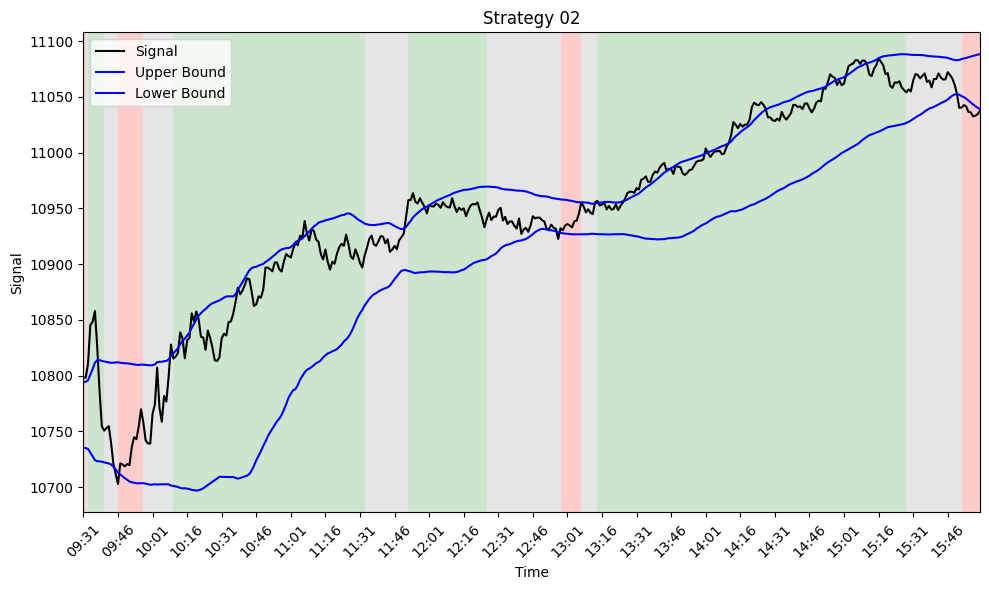

NQ             float64
SP             float64
NQ_SMA60       float64
NQ_STD60       float64
position3      float64
NQ_VB_lower    float64
NQ_VB_upper    float64
upper_1        float64
upper_2        float64
upper_3        float64
lower_1        float64
lower_2        float64
lower_3        float64
position_3        int8
regime_3          int8
dtype: object

In [31]:
plot_positions_vb(
    data_plot=dataQ1,
    date_plot="2023-01-06",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 02"
)
dataQ1.dtypes

## Strategy 02 (OOS)

In [32]:
file_path = "/Users/shah/CODE_BOOK_3/code_document/hfdProject/HFD-Final-Project/data/data1_2023_Q3.parquet"
dataQ3 = pd.read_parquet(file_path)
dataQ3


,datetime,NQ,SP
0,2023-07-03 09:31:00+00:00,15187.069,4442.692
1,2023-07-03 09:32:00+00:00,15204.149,4443.182
2,2023-07-03 09:33:00+00:00,15205.739,4444.906
3,2023-07-03 09:34:00+00:00,15203.729,4446.687
4,2023-07-03 09:35:00+00:00,15200.169,4446.889
...,...,...,...
25143,2023-09-29 15:56:00+00:00,14703.129,4285.614
25144,2023-09-29 15:57:00+00:00,14705.529,4285.382
25145,2023-09-29 15:58:00+00:00,14723.299,4290.132
25146,2023-09-29 15:59:00+00:00,14715.569,4288.376


In [33]:
dataQ3['NQ_SMA60'] = dataQ3['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ3['NQ_SMA60'] = dataQ3['NQ_SMA60'].where(~dataQ3['NQ'].isna(), np.nan)
dataQ3['NQ_STD60'] = dataQ3['NQ'].rolling(window = 60, min_periods = 30).std()

## code1

In [34]:
import numpy as np
import pandas as pd
FLIP = True
dataQ3["upper_1"] = dataQ3["NQ_SMA60"] + k1 * dataQ3["NQ_STD60"]
dataQ3["upper_2"] = dataQ3["NQ_SMA60"] + k2 * dataQ3["NQ_STD60"]
dataQ3["upper_3"] = dataQ3["NQ_SMA60"] + k3 * dataQ3["NQ_STD60"]

dataQ3["lower_1"] = dataQ3["NQ_SMA60"] - k1 * dataQ3["NQ_STD60"]
dataQ3["lower_2"] = dataQ3["NQ_SMA60"] - k2 * dataQ3["NQ_STD60"]
dataQ3["lower_3"] = dataQ3["NQ_SMA60"] - k3 * dataQ3["NQ_STD60"]

# ---------- Preconditions ----------
NQ = dataQ3["NQ"].to_numpy()
SMA   = dataQ3["NQ_SMA60"].to_numpy()

U1 = dataQ3["upper_1"].to_numpy()
U2 = dataQ3["upper_2"].to_numpy()
L1 = dataQ3["lower_1"].to_numpy()
L2 = dataQ3["lower_2"].to_numpy()

n = len(dataQ3)

# ---------- Outputs ----------
pos    = np.zeros(n, dtype=np.int8)   # -1, 0, +1
regime = np.zeros(n, dtype=np.int8)   # 0 = MR, 1 = MOM

# ---------- State ----------
mode    = 0        # 0 = MR, 1 = MOM
persist = 0        # persistence counter
D1      = 10       # persistence threshold (from freq analysis)

# ---------- Main loop ----------
for t in range(1, n):

    # skip until bands exist
    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    # -----------------------------
    # Track downside persistence
    # -----------------------------
    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    # -----------------------------
    # Regime switch: MR → MOM
    # -----------------------------
    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = -1
        regime[t] = mode
        continue

    # -----------------------------
    # Regime switch: MOM → MR
    # -----------------------------
    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    # -----------------------------
    # Mean Reversion logic
    # -----------------------------
    if mode == 0:

        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = 1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = -1
            else:
                pos[t] = 0

        else:
            # exit MR at mean
            if (pos[t-1] == 1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == -1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        # hold momentum position until regime exit
        pos[t] = pos[t-1]

    regime[t] = mode

# ---------- Save ----------
dataQ3["position_3"] = (-pos if FLIP else pos)
dataQ3["regime_3"]   = regime



In [35]:
dataQ3.columns

Index(['datetime', 'NQ', 'SP', 'NQ_SMA60', 'NQ_STD60', 'upper_1', 'upper_2',
       'upper_3', 'lower_1', 'lower_2', 'lower_3', 'position_3', 'regime_3'],
      dtype='object')

In [40]:
dataQ3 = dataQ3.set_index("datetime")
dataQ3.index

DatetimeIndex(['2023-07-03 09:31:00+00:00', '2023-07-03 09:32:00+00:00',
               '2023-07-03 09:33:00+00:00', '2023-07-03 09:34:00+00:00',
               '2023-07-03 09:35:00+00:00', '2023-07-03 09:36:00+00:00',
               '2023-07-03 09:37:00+00:00', '2023-07-03 09:38:00+00:00',
               '2023-07-03 09:39:00+00:00', '2023-07-03 09:40:00+00:00',
               ...
               '2023-09-29 15:51:00+00:00', '2023-09-29 15:52:00+00:00',
               '2023-09-29 15:53:00+00:00', '2023-09-29 15:54:00+00:00',
               '2023-09-29 15:55:00+00:00', '2023-09-29 15:56:00+00:00',
               '2023-09-29 15:57:00+00:00', '2023-09-29 15:58:00+00:00',
               '2023-09-29 15:59:00+00:00', '2023-09-29 16:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='datetime', length=25148, freq=None)

In [41]:
dataQ3.head(1)

,NQ,SP,NQ_SMA60,NQ_STD60,upper_1,upper_2,upper_3,lower_1,lower_2,lower_3,position_3,regime_3
datetime,,,,,,,,,,,,
2023-07-03 09:31:00+00:00,15187.069,4442.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


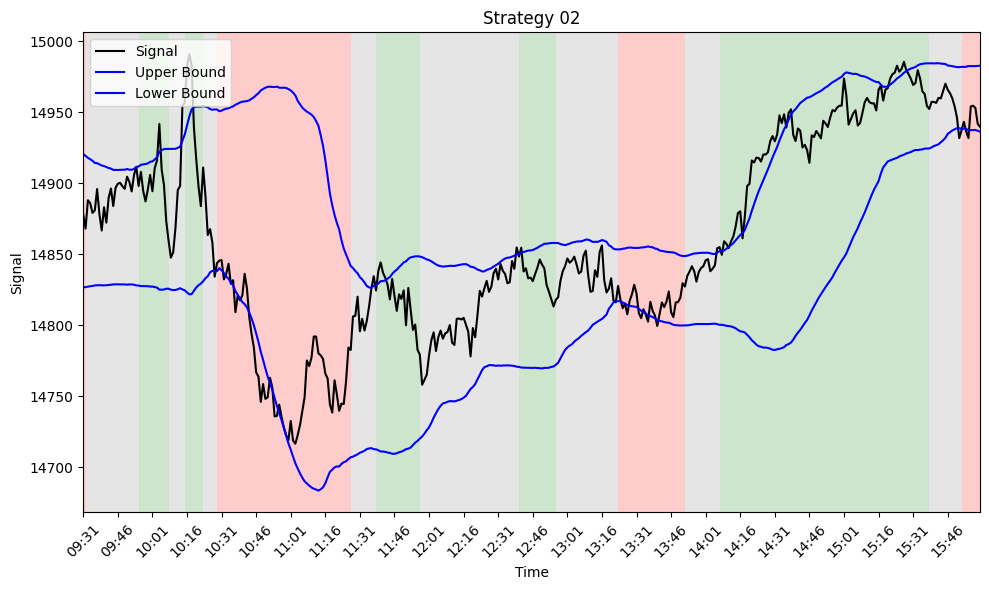

NQ            float64
SP            float64
NQ_SMA60      float64
NQ_STD60      float64
upper_1       float64
upper_2       float64
upper_3       float64
lower_1       float64
lower_2       float64
lower_3       float64
position_3       int8
regime_3         int8
dtype: object

In [43]:
plot_positions_vb(
    data_plot=dataQ3,
    date_plot="2023-08-25",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 02"
)
dataQ3.dtypes

## Parameter tuning


In [51]:
import numpy as np
import pandas as pd
FLIP = False

entry_t = None
entry_price = None

# ---------- Preconditions ----------
dataQ3["upper_1"] = dataQ3["NQ_SMA60"] + k1 * dataQ3["NQ_STD60"]
dataQ3["upper_2"] = dataQ3["NQ_SMA60"] + k2 * dataQ3["NQ_STD60"]
dataQ3["upper_3"] = dataQ3["NQ_SMA60"] + k3 * dataQ3["NQ_STD60"]

dataQ3["lower_1"] = dataQ3["NQ_SMA60"] - k1 * dataQ3["NQ_STD60"]
dataQ3["lower_2"] = dataQ3["NQ_SMA60"] - k2 * dataQ3["NQ_STD60"]
dataQ3["lower_3"] = dataQ3["NQ_SMA60"] - k3 * dataQ3["NQ_STD60"]

NQ = dataQ3["NQ"].to_numpy()
SMA   = dataQ3["NQ_SMA60"].to_numpy()

U1 = dataQ3["upper_1"].to_numpy()
U2 = dataQ3["upper_2"].to_numpy()
L1 = dataQ3["lower_1"].to_numpy()
L2 = dataQ3["lower_2"].to_numpy()

n = len(dataQ3)
# m_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
m_list = list(np.arange(1,90))
best_score = -np.inf

for m in m_list:
    # RESET state per m
    mode = 0
    persist = 0
    pos = np.zeros(n, dtype=np.int8)
    regime = np.zeros(n, dtype=np.int8)
    entry_t = None  
    entry_price = None

    for t in range(1, n):

        if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
            pos[t] = 0
            regime[t] = mode
            continue

        # downside persistence (your logic)
        persist = persist + 1 if (t >= 7 and (np.sum(np.diff(NQ[t-7:t]) < 0) >= int(np.ceil(0.8*(7-1))))) else 0

        if mode == 0 and NQ[t-1] < L1[t-1] and persist >= D1:
            mode = 1
            pos[t] = 1
            regime[t] = mode
            continue

        if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
            mode = 0
            pos[t] = 0
            persist = 0
            entry_t = None
            entry_price = None
            regime[t] = mode
            continue

        if mode == 0:
            if pos[t-1] == 0:
                                # ENTRY
                if NQ[t-1] < L1[t-1]:
                    pos[t] = -1
                elif NQ[t-1] > U1[t-1]:
                    pos[t] = +1
                else:
                    pos[t] = 0
            else:
                # default: HOLD
                pos[t] = pos[t-1]

                # EXIT check
                opp_persist = False
                eps = 0.0
                min_hold = 10

                if entry_t is not None and (t - entry_t) >= min_hold and (t - 1) >= m:
                    last_moves = np.diff(NQ[(t-1-m):(t-1+1)])
                    opp_persist = (
                        (pos[t-1] == +1 and np.all(last_moves < -eps)) or
                        (pos[t-1] == -1 and np.all(last_moves >  eps))
                    )

                if opp_persist:
                    pos[t] = 0
                    entry_t = None
                    entry_price = None
        else:
            pos[t] = pos[t-1]
        prev_pos = pos[t-1]
        cur_pos  = pos[t]

        entry_event = (prev_pos == 0 and cur_pos != 0)
        exit_event  = (prev_pos != 0 and cur_pos == 0)
        flip_event  = (prev_pos != 0 and cur_pos != 0 and cur_pos != prev_pos)

        if entry_event or flip_event:
            entry_t = t
            entry_price = NQ[t]

        if exit_event:
            entry_t = None
            entry_price = None
        

        regime[t] = mode
        

# score AFTER the time loop (not inside it)
fee = 0.12
rets = np.zeros(n)
rets[1:] = (NQ[1:] / NQ[:-1]) - 1.0
strat = pos[:-1] * rets[1:]
score = np.nansum(strat) - fee * np.nansum(np.abs(np.diff(pos)))
if score > best_score:
    best_score = score
    best_pos = pos.copy()
    best_regime = regime.copy()
    best_m = m
    dataQ3["pos"] = best_pos

        
print(best_score)
print(best_pos if FLIP else -best_pos)
print(best_m)

-2.018068123060489
[0 0 0 ... 1 1 1]
89
